In [1]:
# Packages laden
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.backend import binary_crossentropy
from matplotlib import pyplot as plt
from math import sqrt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]

In [5]:
# Preprocessing der Rohdaten: 100%
ZR_100new=np.atleast_2d(ZR_100)
if ZR_100new.shape[0]==1:
    ZR_100new=ZR_100new.T
nb_samples_100, nb_series_100 = ZR_100new.shape

In [6]:
# Preprocessing der Rohdaten: 46%
ZR_46new=np.atleast_2d(ZR_46)
if ZR_46new.shape[0]==1:
    ZR_46new=ZR_46new.T
nb_samples_46, nb_series_46 = ZR_46new.shape

In [7]:
# Einteilung in Trainings- und Testdaten: nicht mehr ZR sondern X --> X_train etc
test_size_100=int(0.3*nb_samples_100)
train_100, test_100 = ZR_100[:-test_size_100], ZR_100[-test_size_100:] 

test_size_46=int(0.35*nb_samples_46)
train_46, test_46 = ZR_46[:-test_size_46], ZR_46[-test_size_46:]

In [8]:
# Shape des Input und Outputs anpassen: 100%
look_forward=60
window_size=12
# Trainingsdaten
Xtrain_100=np.atleast_3d(np.array([train_100[start:start+window_size] for start in range(0, train_100.shape[0]-(window_size+look_forward))]))
ytrain_100=train_100[window_size+look_forward:]
qtrain_100=np.atleast_3d([train_100[-(window_size):]])
print(qtrain_100.shape, ytrain_100.shape, Xtrain_100.shape)

# Testdaten
Xtest_100=np.atleast_3d(np.array([test_100[start:start+window_size] for start in range(0, test_100.shape[0]-(window_size+look_forward))]))
ytest_100=test_100[window_size+look_forward:]
qtest_100=np.atleast_3d([test_100[-(window_size):]])
print(qtest_100.shape, ytest_100.shape, Xtest_100.shape)

(1, 12, 1) (533,) (533, 12, 1)
(1, 12, 1) (186,) (186, 12, 1)


In [9]:
# Shape des Input und Outputs anpassen: 46%
# Trainingsdaten
Xtrain_46=np.atleast_3d(np.array([train_46[start:start+window_size] for start in range(0, train_46.shape[0]-(window_size+look_forward))]))
ytrain_46=train_46[window_size+look_forward:]
qtrain_46=np.atleast_3d([train_46[-(window_size):]])
print(qtrain_46.shape, ytrain_46.shape, Xtrain_46.shape)

# Testdaten
Xtest_46=np.atleast_3d(np.array([test_46[start:start+window_size] for start in range(0, test_46.shape[0]-(window_size+look_forward))]))
ytest_46=test_46[window_size+look_forward:]
qtest_46=np.atleast_3d([test_46[-(window_size):]])
print(qtest_46.shape, ytest_46.shape, Xtest_46.shape)

(1, 12, 1) (188,) (188, 12, 1)
(1, 12, 1) (68,) (68, 12, 1)


In [10]:
# Modell zusammenbauen: 
nb_filter_1=32
nb_filter_2=64
nb_filter_3=64
filter_length=2
nb_input_series=1
nb_outputs=1
model= Sequential()
model.add(Convolution1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='relu', 
                        input_shape=(window_size, nb_input_series)))
model.add(Convolution1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='relu'))
model.add(MaxPooling1D())
model.add(Convolution1D(nb_filter=nb_filter_3, filter_length=filter_length, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(nb_outputs, activation='linear')) 
model.compile(loss='mse', optimizer='adam', metrics=['mae']) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(12, 1), filters=32, kernel_size=2)`
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=2)`
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=2)`
  del sys.path[0]


In [11]:
# Modellzusammenfassung
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 32)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total para

In [12]:
# Replizierbarkeit gewährleisten
np.random.seed(2)

In [13]:
# Modellanpassen: 100%
history_reg=model.fit(Xtrain_100, ytrain_100, epochs=200, batch_size=25, validation_data=(Xtest_100, ytest_100))

Train on 533 samples, validate on 186 samples
Epoch 1/200
533/533 [==============================] - 1s 2ms/step - loss: 2390869345.5610 - mean_absolute_error: 40013.9466 - val_loss: 169380900.1398 - val_mean_absolute_error: 11489.8986
Epoch 2/200
533/533 [==============================] - 0s 338us/step - loss: 307024470.9193 - mean_absolute_error: 13480.8337 - val_loss: 70775086.2151 - val_mean_absolute_error: 6408.1448
Epoch 3/200
533/533 [==============================] - 0s 342us/step - loss: 208156627.7974 - mean_absolute_error: 11353.6396 - val_loss: 47989925.5914 - val_mean_absolute_error: 5550.3112
Epoch 4/200
533/533 [==============================] - 0s 396us/step - loss: 208373862.1238 - mean_absolute_error: 11548.7742 - val_loss: 48127159.9785 - val_mean_absolute_error: 5616.3345
Epoch 5/200
533/533 [==============================] - 0s 364us/step - loss: 204017157.1482 - mean_absolute_error: 11476.8721 - val_loss: 48466172.1613 - val_mean_absolute_error: 5678.6676
Epoch 6/

533/533 [==============================] - 0s 411us/step - loss: 193317813.2233 - mean_absolute_error: 10945.1582 - val_loss: 50153557.4409 - val_mean_absolute_error: 5918.0204
Epoch 87/200
533/533 [==============================] - 0s 338us/step - loss: 194281722.0563 - mean_absolute_error: 11153.2587 - val_loss: 43593995.7742 - val_mean_absolute_error: 5236.8926
Epoch 88/200
533/533 [==============================] - 0s 345us/step - loss: 186619552.4203 - mean_absolute_error: 10736.0355 - val_loss: 43787677.5968 - val_mean_absolute_error: 5216.6701
Epoch 89/200
533/533 [==============================] - ETA: 0s - loss: 179463879.4667 - mean_absolute_error: 10731.686 - 0s 343us/step - loss: 190683377.5610 - mean_absolute_error: 11051.2435 - val_loss: 60751660.0108 - val_mean_absolute_error: 5897.5893
Epoch 90/200
533/533 [==============================] - 0s 342us/step - loss: 184160399.3771 - mean_absolute_error: 10849.0285 - val_loss: 43998961.6559 - val_mean_absolute_error: 5341.65

Epoch 129/200
533/533 [==============================] - 0s 413us/step - loss: 178581871.6098 - mean_absolute_error: 10604.6598 - val_loss: 44805703.2527 - val_mean_absolute_error: 5207.3823
Epoch 130/200
533/533 [==============================] - 0s 341us/step - loss: 179775609.5460 - mean_absolute_error: 10741.0740 - val_loss: 44404613.4892 - val_mean_absolute_error: 5300.9176
Epoch 131/200
533/533 [==============================] - 0s 340us/step - loss: 187500949.7186 - mean_absolute_error: 10872.8924 - val_loss: 56547809.7742 - val_mean_absolute_error: 5702.8731
Epoch 132/200
533/533 [==============================] - 0s 328us/step - loss: 178132759.3546 - mean_absolute_error: 10790.4318 - val_loss: 45854952.4462 - val_mean_absolute_error: 5213.3372
Epoch 133/200
533/533 [==============================] - 0s 327us/step - loss: 174566499.1520 - mean_absolute_error: 10625.1659 - val_loss: 43307852.1935 - val_mean_absolute_error: 5191.2038
Epoch 134/200
533/533 [======================

Text(0.5,1,'Loss Curves')

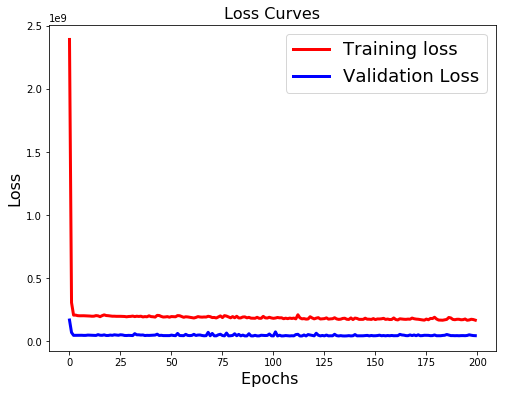

In [14]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

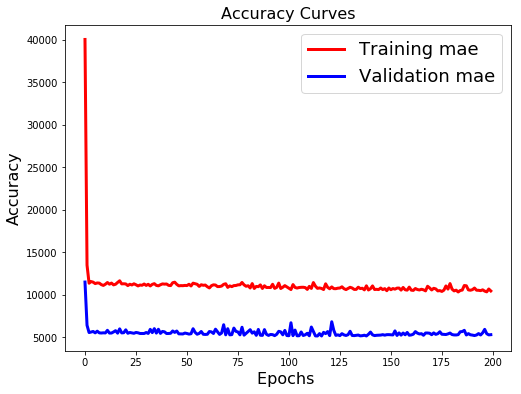

In [15]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [16]:
# Vorhersage generieren
predictions_100 = model.predict(Xtest_100)

predictions_train_100=model.predict(Xtrain_100)

In [17]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_100, predictions_100)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_100, predictions_train_100)
print('Train MSE: %.3f' % mse_train)

Test MSE: 45581435.423
Train MSE: 165117359.152


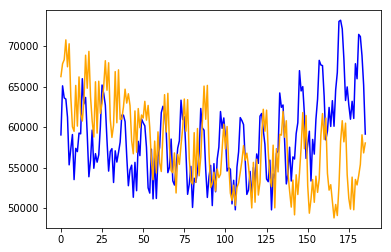

In [18]:
# Vorhersage und Testdaten abtragen
plt.plot(ytest_100, color='blue') # blau: original
plt.plot(predictions_100, color='orange') # orange
plt.show()

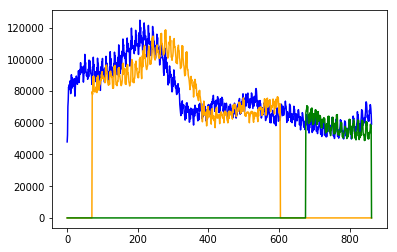

In [19]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_100)+(window_size+look_forward-1)] = predictions_train_100


# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(predictions_train_100)+2*(window_size+look_forward)-1:len(ZR_100)-1] = predictions_100
     
       
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()

In [38]:
# Replizierbarkeit gewährleisten
np.random.seed(7)

In [39]:
# Modellanpassen: 46%
history_reg=model.fit(Xtrain_46, ytrain_46, epochs=200, batch_size=25, validation_data=(Xtest_46, ytest_46))

Train on 188 samples, validate on 68 samples
Epoch 1/200
188/188 [==============================] - 0s 404us/step - loss: 18776164.6330 - mean_absolute_error: 3701.2262 - val_loss: 116130356.5882 - val_mean_absolute_error: 9466.2478
Epoch 2/200
188/188 [==============================] - 0s 362us/step - loss: 19504660.5266 - mean_absolute_error: 3565.4708 - val_loss: 77188035.0735 - val_mean_absolute_error: 7358.3944
Epoch 3/200
188/188 [==============================] - 0s 436us/step - loss: 19154135.8883 - mean_absolute_error: 3496.2682 - val_loss: 81071000.9559 - val_mean_absolute_error: 7574.4489
Epoch 4/200
188/188 [==============================] - 0s 489us/step - loss: 19389191.5266 - mean_absolute_error: 3778.1073 - val_loss: 113032915.5882 - val_mean_absolute_error: 9312.7541
Epoch 5/200
188/188 [==============================] - 0s 580us/step - loss: 17371959.4840 - mean_absolute_error: 3510.3055 - val_loss: 101666751.7794 - val_mean_absolute_error: 8766.1767
Epoch 6/200
188/1

188/188 [==============================] - 0s 436us/step - loss: 16157442.1383 - mean_absolute_error: 3322.8232 - val_loss: 88314072.6471 - val_mean_absolute_error: 8043.4371
Epoch 88/200
188/188 [==============================] - 0s 590us/step - loss: 17536712.3032 - mean_absolute_error: 3425.0399 - val_loss: 108656448.9412 - val_mean_absolute_error: 9117.0231
Epoch 89/200
188/188 [==============================] - 0s 372us/step - loss: 16842930.9415 - mean_absolute_error: 3517.0429 - val_loss: 116876647.5294 - val_mean_absolute_error: 9486.0229
Epoch 90/200
188/188 [==============================] - 0s 383us/step - loss: 16296884.7128 - mean_absolute_error: 3281.0839 - val_loss: 78805788.8088 - val_mean_absolute_error: 7469.5038
Epoch 91/200
188/188 [==============================] - 0s 436us/step - loss: 17217990.4734 - mean_absolute_error: 3494.3124 - val_loss: 125969133.7941 - val_mean_absolute_error: 9960.5030
Epoch 92/200
188/188 [==============================] - 0s 441us/step 

188/188 [==============================] - 0s 420us/step - loss: 16299509.8670 - mean_absolute_error: 3362.3844 - val_loss: 113194719.1765 - val_mean_absolute_error: 9323.7867
Epoch 131/200
188/188 [==============================] - 0s 489us/step - loss: 15872423.3511 - mean_absolute_error: 3338.5611 - val_loss: 98997029.9853 - val_mean_absolute_error: 8587.7283
Epoch 132/200
188/188 [==============================] - 0s 457us/step - loss: 17729418.2181 - mean_absolute_error: 3396.3067 - val_loss: 78879508.9559 - val_mean_absolute_error: 7476.7953
Epoch 133/200
188/188 [==============================] - 0s 489us/step - loss: 18142375.1011 - mean_absolute_error: 3509.1002 - val_loss: 87365560.0882 - val_mean_absolute_error: 7948.3832
Epoch 134/200
188/188 [==============================] - 0s 473us/step - loss: 16635957.0106 - mean_absolute_error: 3445.3757 - val_loss: 112755288.2353 - val_mean_absolute_error: 9305.2625
Epoch 135/200
188/188 [==============================] - 0s 511us/s

Text(0.5,1,'Loss Curves')

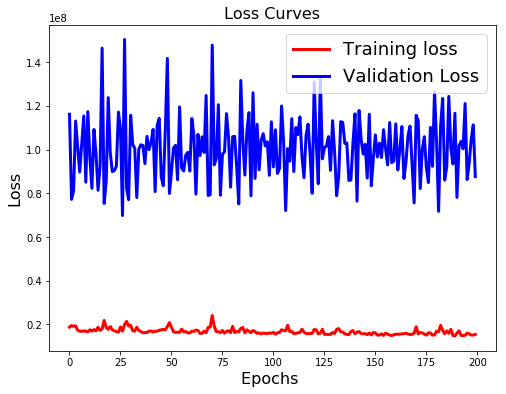

In [40]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

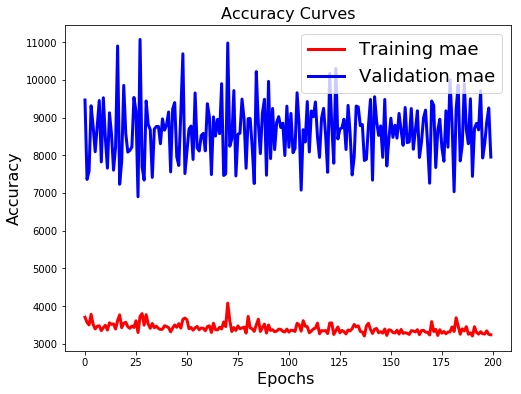

In [41]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [42]:
# Vorhersage generieren
predictions_46 = model.predict(Xtest_46)

predictions_train_46=model.predict(Xtrain_46)

In [43]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_46, predictions_46)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_46, predictions_train_46)
print('Train MSE: %.3f' % mse_train)

Test MSE: 87602864.413
Train MSE: 15540936.518


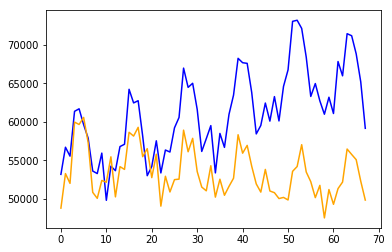

In [44]:
# Vorhersage und Testdaten abtragen
plt.plot(ytest_46, color='blue') 
plt.plot(predictions_46, color='orange')
plt.show()

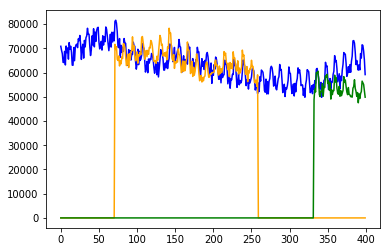

In [45]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_46)
trainPredictPlot[:]=[0]*len(ZR_46)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_46),1)
trainPredictPlot[(window_size+look_forward-1):len(predictions_train_46)+(window_size+look_forward-1)] = predictions_train_46

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_46)
testPredictPlot[:]=[0]*len(ZR_46)
testPredictPlot = testPredictPlot.reshape(len(ZR_46),1)
testPredictPlot[len(predictions_train_46)+2*(window_size+look_forward):len(ZR)-1] = predictions_46
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_46, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()